In [1]:
import yaml
import umap

import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from math import floor
from scipy.stats import mannwhitneyu

from carot.utils import get_source_target_transport, score_transports_and_targets_combinations
from cmonge.utils import load_config
from carot.trainers.conditional_monge_trainer import ConditionalMongeTrainer
from carot.datasets.conditional_loader import ConditionalDataModule

/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sns.set(font="Arial")
sns.set_context("paper")
sns.set_style("whitegrid")
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['ytick.left'] = True
mpl.rcParams['xtick.bottom'] = True

In [3]:
default_colors = {
    "indigo": "#332288",
    "cyan": "#88CCEE",
    "teal": "#44AA99",
    "green": "#117733",
    "olive": "#999933",
    "sand": "#DDCC77",
    "rose": "#CC6677",
    "wine": "#882255",
    "purple": "#AA4499",
    "grey": "#DDDDDD",
}

eval_setting_map = {
    "identity": default_colors["wine"],
    "CAROT": default_colors["cyan"],
    "conCAROT": default_colors["indigo"],
    "conCAROT-OOD": default_colors["indigo"],
    "within condition": default_colors["green"],
    "chemCPA": default_colors["sand"],
    "avg CAR": default_colors["rose"]
}

geneset_map = {
    "functional": default_colors["olive"],
    "functional+score": default_colors["rose"],
    "HVG": default_colors["teal"],
    "random": default_colors["sand"],
}

subset_map = {
    "CD4": default_colors["teal"],
    "CD8": default_colors["purple"],
}

ot_map = {
    "source": default_colors["cyan"],
    "target": default_colors["sand"],
    "transport": default_colors["rose"],
    "rest": default_colors["grey"]
}

sel_cars = ['CD40-CD40-z', "IL15RA-CD40-z", "CD28-CTLA4-z"]
sc_palette = {'CD40-CD40-z': default_colors["sand"],
             "IL15RA-CD40-z": default_colors["cyan"],
             "CD28-CTLA4-z": default_colors["rose"]}
sc_markers = {'CD40-CD40-z': "s",
             "IL15RA-CD40-z": "^",
             "CD28-CTLA4-z": "X"}

In [4]:
features = "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/functional_and_score_genes.txt"

logger_path = "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/conditional-monge/experiments/cmonge_ood/sel_CARs_ood/"
base_config_path = "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/conditional-monge/experiments/cmonge/sel_CARs_LN_True_grad_acc_4_cosine/"
base_ckpt_path = "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/conditional-monge/experiments/cmonge/sel_CARs_LN_True_grad_acc_4_cosine/"
base_fig_save = "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Figures/cmonge/ood/sel_CARs_"

In [5]:
# conCAROT-OOD
all_mean_metrics=[]
for subset in ["CD4", "CD8"]:
    for setting in ["identity", "cmonge", "within condition"]:
        with open(f"{logger_path}model_sel_cars_{subset}_{setting}_small_CARs_eval.yaml",) as stream:
            logs = yaml.safe_load(stream)
            
        for i in range(len(logs["experiments"])):
            for condition, results in logs["experiments"][i]["valid-set"].items():
                res = pd.Series(results["mean_statistics"])
                res = res.reset_index(drop=False).rename(columns={"index": "metric", 0: "score"})
                res["eval_car"] = condition
                res["eval_setting"] = setting
                res["subset"] = subset
                all_mean_metrics.append(res)

In [6]:
OOD_res = pd.concat(all_mean_metrics).reset_index(drop=True)
OOD_res = OOD_res[~OOD_res["eval_car"].isin(["NA-NA-NA", "NA-NA-z"])]
OOD_res["eval_setting"] = ["conCAROT-OOD" if "cmonge" in s else s for s in OOD_res["eval_setting"]]

In [7]:
# avgerage CAR model
all_mean_metrics = []

for subset in ["CD4", "CD8"]:
    with open(f"{logger_path}model_sel_cars_{subset}_avg_CAR_OOD_CARs_eval.yaml",) as stream:
            logs = yaml.safe_load(stream)
            
    for i in range(len(logs["experiments"])):
        for condition, results in logs["experiments"][i]["valid-set"].items():
            res = pd.Series(results["mean_statistics"])
            res = res.reset_index(drop=False).rename(columns={"index": "metric", 0: "score"})
            res["eval_car"] = condition
            res["eval_setting"] = "avg CAR"
            res["subset"] = subset
            all_mean_metrics.append(res)
avg_CAR_res = pd.concat(all_mean_metrics).reset_index(drop=True)
avg_CAR_res = avg_CAR_res[~avg_CAR_res["eval_car"].isin(["NA-NA-NA", "NA-NA-z"])]
avg_CAR_res

,metric,score,eval_car,eval_setting,subset
0,mean_wasserstein,6.501269,41BB-CTLA4-z,avg CAR,CD4
1,mean_mmd,0.024311,41BB-CTLA4-z,avg CAR,CD4
2,mean_sinkhorn div,6.037186,41BB-CTLA4-z,avg CAR,CD4
3,mean_monge_gap,11.527459,41BB-CTLA4-z,avg CAR,CD4
4,mean_drug_signature,1.420583,41BB-CTLA4-z,avg CAR,CD4
...,...,...,...,...,...
175,mean_mmd,0.018064,IL15RA-IL15RA-z,avg CAR,CD8
176,mean_sinkhorn div,6.338229,IL15RA-IL15RA-z,avg CAR,CD8
177,mean_monge_gap,12.068927,IL15RA-IL15RA-z,avg CAR,CD8
178,mean_drug_signature,1.321423,IL15RA-IL15RA-z,avg CAR,CD8


In [8]:
avg_CAR_res[["eval_car", "subset"]].drop_duplicates().groupby("subset").size()

subset
CD4    14
CD8    16
dtype: int64

In [9]:
chemcpa = pd.read_csv("/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/chemCPA/OOD_CD4_CD8_carot_results.csv", index_col=0)
chemcpa = chemcpa[~chemcpa["eval_car"].isin(["NA-NA-NA", "NA-NA-z"])]

OOD_res = pd.concat([OOD_res, chemcpa, avg_CAR_res])
OOD_res

,metric,score,eval_car,eval_setting,subset
0,mean_wasserstein,6.439516,41BB-CTLA4-z,identity,CD4
1,mean_mmd,0.029646,41BB-CTLA4-z,identity,CD4
2,mean_sinkhorn div,5.920317,41BB-CTLA4-z,identity,CD4
3,mean_monge_gap,11.336957,41BB-CTLA4-z,identity,CD4
4,mean_drug_signature,2.412503,41BB-CTLA4-z,identity,CD4
...,...,...,...,...,...
175,mean_mmd,0.018064,IL15RA-IL15RA-z,avg CAR,CD8
176,mean_sinkhorn div,6.338229,IL15RA-IL15RA-z,avg CAR,CD8
177,mean_monge_gap,12.068927,IL15RA-IL15RA-z,avg CAR,CD8
178,mean_drug_signature,1.321423,IL15RA-IL15RA-z,avg CAR,CD8


In [10]:
pvals = []
metrics = []
subsets = []
comparisons = []
for metric in ["mean_mmd", "mean_r2"]:
    for subset in ["CD8", "CD4"]:
        for comparison in [("conCAROT-OOD", "identity"), ("conCAROT-OOD", "within condition"), 
                           ("conCAROT-OOD", "chemCPA"), ("chemCPA", "within condition"), ("chemCPA", "identity"),
                           ("conCAROT-OOD", "avg CAR"), ("chemCPA", "avg CAR")]:
            sel_res = OOD_res[(OOD_res["metric"]==metric)&(OOD_res["subset"]==subset)]
           
            pval = mannwhitneyu(sel_res.loc[sel_res["eval_setting"]==comparison[0], "score"], 
                                sel_res.loc[sel_res["eval_setting"]==comparison[1], 'score'],
                               ).pvalue 
            pvals.append(pval)
            metrics.append(metric)
            subsets.append(subset)
            comparisons.append(comparison)
stats = pd.DataFrame({"pval": pvals, "subset": subsets, "metric": metrics})
stats[["setting1", "setting2"]] = comparisons
stats["corr_pval"] = stats["pval"] *len(stats)
stats["treshold"] = 0.05/len(stats)
stats["significant1"] =  stats["pval"] < stats["treshold"]
stats["significant2"] =  stats["corr_pval"] < 0.05
stats

,pval,subset,metric,setting1,setting2,corr_pval,treshold,significant1,significant2
0,0.000026,CD8,mean_mmd,conCAROT-OOD,identity,0.000740,0.001786,True,True
1,0.000002,CD8,mean_mmd,conCAROT-OOD,within condition,0.000043,0.001786,True,True
2,0.000002,CD8,mean_mmd,conCAROT-OOD,chemCPA,0.000043,0.001786,True,True
3,0.000002,CD8,mean_mmd,chemCPA,within condition,0.000043,0.001786,True,True
4,0.000002,CD8,mean_mmd,chemCPA,identity,0.000043,0.001786,True,True
5,0.013563,CD8,mean_mmd,conCAROT-OOD,avg CAR,0.379774,0.001786,False,False
6,0.000002,CD8,mean_mmd,chemCPA,avg CAR,0.000043,0.001786,True,True
7,0.000732,CD4,mean_mmd,conCAROT-OOD,identity,0.020507,0.001786,True,True
8,0.000007,CD4,mean_mmd,conCAROT-OOD,within condition,0.000209,0.001786,True,True
9,0.000007,CD4,mean_mmd,conCAROT-OOD,chemCPA,0.000209,0.001786,True,True


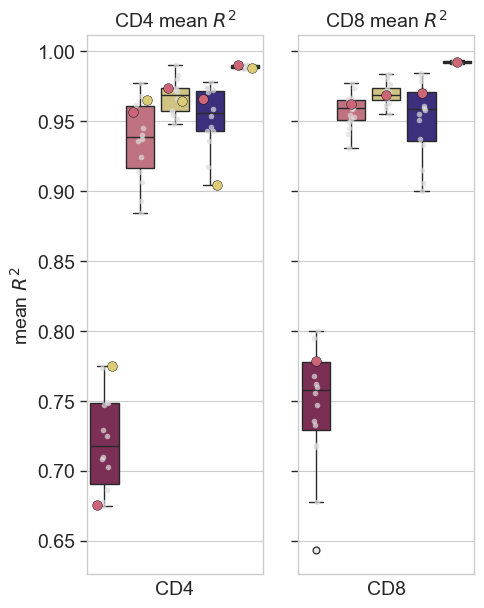

In [11]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(5,7))
for i, subset in enumerate(["CD4", "CD8"]):
    plt_data = OOD_res[(OOD_res["subset"]==subset)&(OOD_res["metric"]=="mean_r2")]
    plt_data = plt_data.rename(columns={"eval_setting": ""})
    sns.boxplot(data=plt_data, y="score", x="", hue="", ax=axes[i], palette=eval_setting_map,
               order=["identity", "avg CAR", "chemCPA", "conCAROT-OOD", "within condition"])
    sns.stripplot(data=plt_data[~plt_data["eval_car"].isin(sel_cars)], y="score", x = "", s=4,
                  ax=axes[i], color=default_colors["grey"], dodge=True, legend=False, alpha=0.7)
    sns.stripplot(data=plt_data[plt_data["eval_car"].isin(sel_cars)], y="score", x = "", ax=axes[i], hue="eval_car", s=7, 
                  edgecolor="black", linewidth=0.3, 
                  dodge=True, palette=sc_palette, legend=False)
    axes[i].set_title(f"{subset} mean $R^2$", fontsize=14)
    axes[i].set_ylabel("mean $R^2$", fontsize=14)
    axes[i].tick_params(which="both", axis="both", labelsize=14)
    axes[i].set_xticklabels([])
    axes[i].set_xticks([])
    axes[i].set_xlabel(f"{subset}", fontsize=14)

# axes[0].get_legend().remove()
# axes[1].legend(fontsize=12, loc="lower center")
plt.tick_params(which="both", axis="both", labelsize=14)
plt.savefig(f"{base_fig_save}R2_performance.pdf", bbox_inches="tight")

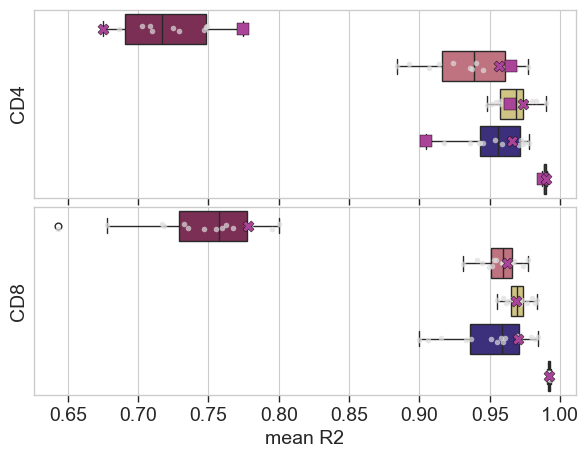

In [12]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(7,5))
for i, subset in enumerate(["CD4", "CD8"]):
    plt_data = OOD_res[(OOD_res["subset"]==subset)&(OOD_res["metric"]=="mean_r2")]
    plt_data = plt_data.rename(columns={"eval_setting": ""})
    sns.boxplot(data=plt_data, x="score", y="", hue="", ax=axes[i], palette=eval_setting_map,
               order=["identity", "avg CAR", "chemCPA", "conCAROT-OOD", "within condition"])
    sns.stripplot(data=plt_data[~plt_data["eval_car"].isin(sel_cars)], x="score", y="", s=4,
                  ax=axes[i], color=default_colors["grey"], dodge=True, legend=False, alpha=0.7)
    for car in sel_cars:
        sns.stripplot(data=plt_data[plt_data["eval_car"]==car], x="score", y="", ax=axes[i],
                        color=default_colors["purple"],  s=8,  edgecolor="black", marker=sc_markers[car],
                      linewidth=0.3, legend=False)
    axes[i].set_ylabel(f"{subset}", fontsize=14)
    axes[i].tick_params(which="both", axis="both", labelsize=14)
    axes[i].set_yticklabels([])
    axes[i].set_yticks([])
    axes[i].set_xlabel("")

# axes[0].get_legend().remove()
# axes[1].legend(fontsize=12, loc="lower center")
axes[1].set_xlabel("mean R2", fontsize=14)
plt.tick_params(which="both", axis="both", labelsize=14)
plt.subplots_adjust(wspace=None, hspace=0.05)
plt.savefig(f"{base_fig_save}R2_performance_horizontal.pdf", bbox_inches="tight")

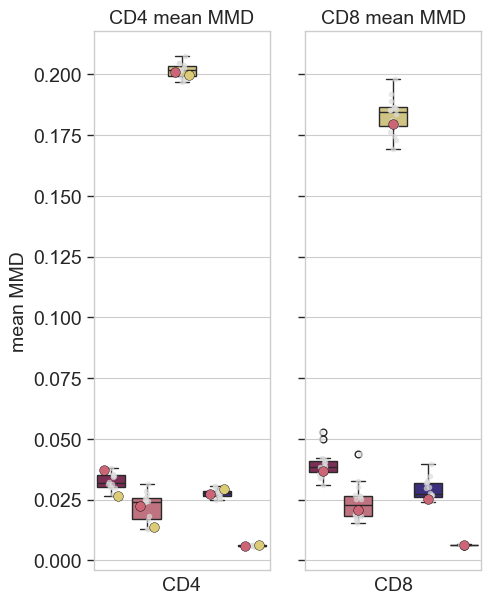

In [13]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(5,7))
for i, subset in enumerate(["CD4", "CD8"]):
    plt_data = OOD_res[(OOD_res["subset"]==subset)&(OOD_res["metric"]=="mean_mmd")]
    plt_data = plt_data.rename(columns={"eval_setting": ""})
    sns.boxplot(data=plt_data, y="score", x="", hue="", ax=axes[i], palette=eval_setting_map,
               order=["identity", "avg CAR", "chemCPA", "conCAROT-OOD", "within condition"])
    sns.stripplot(data=plt_data[~plt_data["eval_car"].isin(sel_cars)], y="score", x = "", s=4,
                  ax=axes[i], color=default_colors["grey"], dodge=True, legend=False, alpha=0.7)
    sns.stripplot(data=plt_data[plt_data["eval_car"].isin(sel_cars)], y="score", x = "", ax=axes[i], hue="eval_car", s=7, 
                  edgecolor="black", linewidth=0.3, 
                  dodge=True, palette=sc_palette, legend=False)
    axes[i].set_title(f"{subset} mean MMD", fontsize=14)
    axes[i].set_ylabel("mean MMD", fontsize=14)
    axes[i].tick_params(which="both", axis="both", labelsize=14)
    axes[i].set_xticklabels([])
    axes[i].set_xticks([])
    axes[i].set_xlabel(f"{subset}", fontsize=14)

# axes[0].get_legend().remove()
# axes[1].legend(fontsize=12, loc="lower center")
plt.tick_params(which="both", axis="both", labelsize=14)
plt.savefig(f"{base_fig_save}MMD_performance.pdf", bbox_inches="tight")

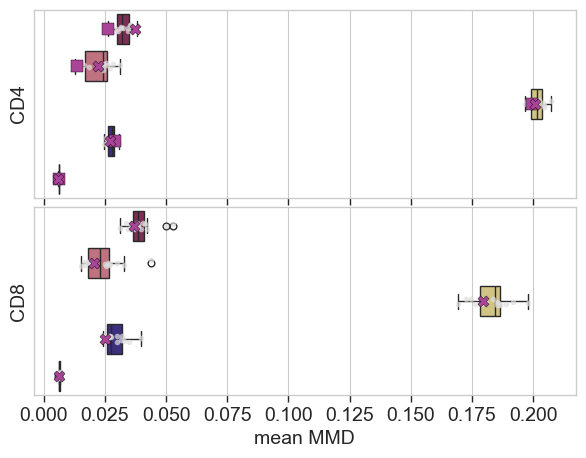

In [14]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(7,5))
for i, subset in enumerate(["CD4", "CD8"]):
    plt_data = OOD_res[(OOD_res["subset"]==subset)&(OOD_res["metric"]=="mean_mmd")]
    plt_data = plt_data.rename(columns={"eval_setting": ""})
    sns.boxplot(data=plt_data, x="score", y="", hue="", ax=axes[i], palette=eval_setting_map,
               order=["identity", "avg CAR", "chemCPA", "conCAROT-OOD", "within condition"])
    sns.stripplot(data=plt_data[~plt_data["eval_car"].isin(sel_cars)], x="score", y="", s=4,
                  ax=axes[i], color=default_colors["grey"], dodge=True, legend=False, alpha=0.7)
    for car in sel_cars:
        sns.stripplot(data=plt_data[plt_data["eval_car"]==car], x="score", y="", ax=axes[i],
                        color=default_colors["purple"],  s=8,  edgecolor="black", marker=sc_markers[car],
                      linewidth=0.3, legend=False)
    axes[i].set_ylabel(f"{subset}", fontsize=14)
    axes[i].tick_params(which="both", axis="both", labelsize=14)
    axes[i].set_yticklabels([])
    axes[i].set_yticks([])
    axes[i].set_xlabel("")

# axes[0].get_legend().remove()
# axes[1].legend(fontsize=12, loc="lower center")
axes[1].set_xlabel("mean MMD", fontsize=14)
plt.tick_params(which="both", axis="both", labelsize=14)
plt.subplots_adjust(wspace=None, hspace=0.05)
plt.savefig(f"{base_fig_save}MMD_performance_horizontal.pdf", bbox_inches="tight")

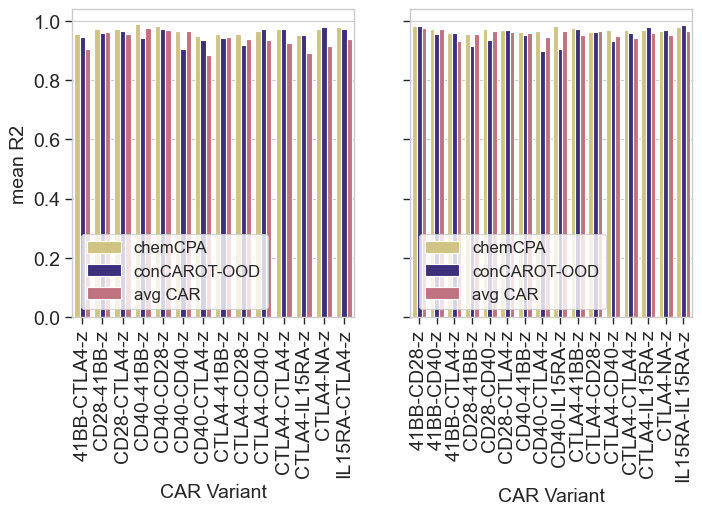

In [15]:
plt_data = OOD_res[(OOD_res["metric"]=="mean_r2")&(OOD_res["eval_setting"].isin(["conCAROT-OOD", "avg CAR", "chemCPA"]))]
fig, ax = plt.subplots(1, 2, figsize=(8,4), sharey=True)
ax = ax.flatten()
sns.barplot(data=plt_data[plt_data["subset"]=="CD4"], y="score", x="eval_car", hue="eval_setting", palette=eval_setting_map, ax=ax[0], 
                hue_order=["chemCPA", "conCAROT-OOD", "avg CAR"])
sns.barplot(data=plt_data[plt_data["subset"]=="CD8"], y="score", x="eval_car", hue="eval_setting", palette=eval_setting_map, ax=ax[1], 
                hue_order=["chemCPA", "conCAROT-OOD", "avg CAR"])
ax[0].set_xlabel("CAR Variant", fontsize=14)
ax[0].set_ylabel("mean R2", fontsize=14)
ax[0].tick_params(which="both", axis="both", labelsize=14)
ax[0].tick_params(axis="x", labelrotation=90)
ax[0].legend(loc="lower left", title="", fontsize=12)

ax[1].set_xlabel("CAR Variant", fontsize=14)
ax[1].set_ylabel("mean R2", fontsize=14)
ax[1].tick_params(which="both", axis="both", labelsize=14)
ax[1].tick_params(axis="x", labelrotation=90)
ax[1].legend(loc="lower left", title="", fontsize=12)

plt.savefig(f"{base_fig_save}sel_CARs_R2_per_car_horizontal.pdf", bbox_inches="tight")
plt.show()

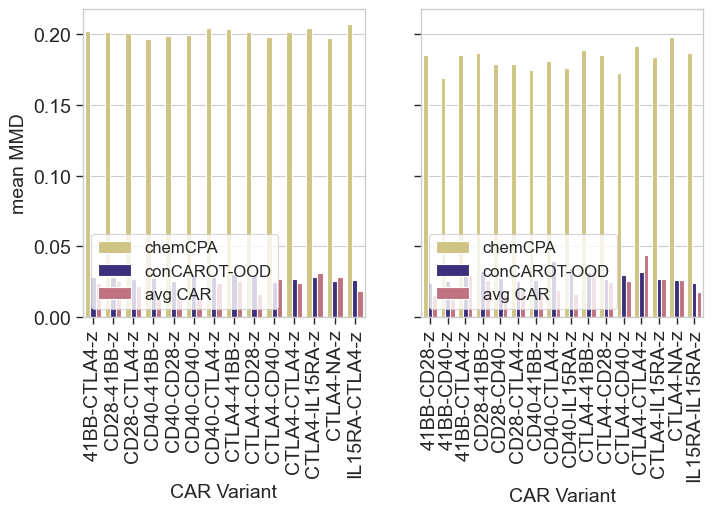

In [16]:
plt_data = OOD_res[(OOD_res["metric"]=="mean_mmd")&(OOD_res["eval_setting"].isin(["conCAROT-OOD", "avg CAR", "chemCPA"]))]
fig, ax = plt.subplots(1, 2, figsize=(8,4), sharey=True)
ax = ax.flatten()
sns.barplot(data=plt_data[plt_data["subset"]=="CD4"], y="score", x="eval_car", hue="eval_setting", palette=eval_setting_map, ax=ax[0], 
                hue_order=["chemCPA", "conCAROT-OOD", "avg CAR"])
sns.barplot(data=plt_data[plt_data["subset"]=="CD8"], y="score", x="eval_car", hue="eval_setting", palette=eval_setting_map, ax=ax[1], 
                hue_order=["chemCPA", "conCAROT-OOD", "avg CAR"])
ax[0].set_xlabel("CAR Variant", fontsize=14)
ax[0].set_ylabel("mean MMD", fontsize=14)
ax[0].tick_params(which="both", axis="both", labelsize=14)
ax[0].tick_params(axis="x", labelrotation=90)
ax[0].legend(loc="lower left", title="", fontsize=12)

ax[1].set_xlabel("CAR Variant", fontsize=14)
ax[1].set_ylabel("mean MMD", fontsize=14)
ax[1].tick_params(which="both", axis="both", labelsize=14)
ax[1].tick_params(axis="x", labelrotation=90)
ax[1].legend(loc="lower left", title="", fontsize=12)

plt.savefig(f"{base_fig_save}sel_CARs_MMD_per_car.pdf", bbox_inches="tight")
plt.show()

In [17]:
temp = plt_data.pivot_table(columns=["subset", "eval_setting"], values=["score"], index="eval_car").T.reset_index(level=0, drop=True).T
temp[temp[("CD4", "avg CAR")]>temp[("CD4", "conCAROT-OOD")]]
# temp

subset               CD4                              CD8            \
eval_setting     avg CAR   chemCPA conCAROT-OOD   avg CAR   chemCPA   
eval_car                                                              
CTLA4-CD40-z    0.027301  0.198478     0.024725  0.025445  0.172750   
CTLA4-IL15RA-z  0.031294  0.204654     0.028329  0.026915  0.183689   
CTLA4-NA-z      0.028402  0.197658     0.025900  0.026385  0.198009   

subset                       
eval_setting   conCAROT-OOD  
eval_car                     
CTLA4-CD40-z       0.030139  
CTLA4-IL15RA-z     0.027070  
CTLA4-NA-z         0.026505

In [18]:
temp[temp[("CD8", "avg CAR")]>temp[("CD8", "conCAROT-OOD")]]


subset              CD4                              CD8            \
eval_setting    avg CAR   chemCPA conCAROT-OOD   avg CAR   chemCPA   
eval_car                                                             
41BB-CTLA4-z   0.024311  0.202362     0.028147  0.030016  0.185437   
CTLA4-41BB-z   0.025288  0.203944     0.030769  0.032707  0.188948   
CTLA4-CTLA4-z  0.024061  0.201734     0.027268  0.043942  0.191818   

subset                      
eval_setting  conCAROT-OOD  
eval_car                    
41BB-CTLA4-z      0.029769  
CTLA4-41BB-z      0.031754  
CTLA4-CTLA4-z     0.032051

## Compare ID and OOD CARs in different evaluation settings

These next two cells take quite long. After these have been run the results are saved and loaded in the first uncommented block

### ConCAROT trained on CARs with >750 cells

In [19]:
# base_ckpt_path = "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/conditional-monge/experiments/cmonge/sel_CARs_LN_True_grad_acc_4_cosine/"
# base_config_path = "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/conditional-monge/experiments/cmonge/sel_CARs_LN_True_grad_acc_4_cosine/"
# logger_path = "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/conditional-monge/experiments/cmonge_ood/sel_CARs_ood/"

# # setting="cmonge"
# setting="within condition"
# # setting="identity"

# for subset in ["CD4", "CD8"]:
#     adata = sc.read_h5ad(f'/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/{subset}.h5ad')
#     adata.X = adata.layers['logcounts']
#     with open(features, "r") as f:
#         genes = f.read().splitlines()
#     sel_adata = adata[:, genes]

#     config_path = f"{base_config_path}{subset}_esm_XL_tail_dim_FuncScore/config.yaml"
#     config = load_config(config_path)
#     config.model.checkpointing_path = f"{base_ckpt_path}{subset}_esm_XL_tail_dim_FuncScore/model"
#     config.data.file_path = f"/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/{subset}.h5ad"
#     config.data.features = features
#     config.data.drugs_path = f"/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/{subset}_sel_cars.txt"
#     config.model.embedding.model_dir = "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/embedding/"
    
#     print(config.model.checkpointing_path)

#     with open(config.data.drugs_path) as f:
#         train_cars = f.readlines()
#     train_cars = [c[:-1] for c in train_cars]

#     for car in sel_adata.obs["CAR_Variant"].unique():
#         if car in ["NA-NA-NA", "NA-NA-z"]:
#             continue
#         if car not in train_cars: # HERE ADD/REMOVE A "NOT" TO SWITCH BETWEEN >750 AND <750 CELLS CARS
#             continue
#         config.condition.split = [0,1,0]
#         config.data.split = [0,1,0]
#         # batch_size = min(sum(sel_adata.obs["CAR_Variant"]==car), sum(sel_adata.obs["CAR_Variant"]=="NA-NA-NA"))
#         # batch_size = floor(batch_size * config.data.split[1] / 9) # 9 in n_samples of the evaluation modules

#         # config.data.batch_size=batch_size
#         config.condition.conditions = [car]

#         if setting=="within condition":
#             config.data.control_condition=car
        
#         datamodule = ConditionalDataModule(config.data, config.condition, config.ae)
#         trainer = ConditionalMongeTrainer.load_checkpoint(
#             jobid=1,
#             logger_path=f"{logger_path}model_sel_cars_{subset}_{setting}_sel_cars_eval.yaml", # HERE CHANGE BETWEEN "SMALL" AND "SEL"
#             config=config.model, 
#             datamodule=datamodule, 
#             ckpt_path=config.model.checkpointing_path
#             )

#         if setting=="identity" or setting=="within condition":
#             trainer.evaluate(datamodule, identity=True)
#         else:
#             trainer.evaluate(datamodule)


### conCAROT trained on all CARs

In [20]:
# base_exp_path = "/Users/alicedriessen/Library/CloudStorage/Box-Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/conditional-monge/experiments"
# logger_path = "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/conditional-monge/experiments/cmonge_ood/sel_CARs_ood/"

# setting="cmonge"

# for subset in ["CD4", "CD8"]:

#     config_path = f"{base_exp_path}/cmonge/LN_True_grad_acc_4_cosine/{subset}_esm_XL_tail_dim_FuncScore/config.yaml"
#     config = load_config(config_path)
#     config.model.checkpointing_path = f"{base_exp_path}/cmonge/LN_True_grad_acc_4_cosine/{subset}_esm_XL_tail_dim_FuncScore/model"
#     config.data.file_path = f"/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/{subset}.h5ad"
#     config.data.features = features
#     config.data.drugs_path = f"/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/{subset}_sel_cars.txt"
#     config.model.embedding.model_dir = "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/embedding/"

#     with open(config.data.drugs_path) as f:
#         train_cars = f.readlines()
#     train_cars = [c[:-1] for c in train_cars]

#     for car in sel_adata.obs["CAR_Variant"].unique():
#         if car in ["NA-NA-NA", "NA-NA-z"]:
#             continue
#         if car not in train_cars: # HERE ADD/REMOVE A "NOT" TO SWITCH BETWEEN >750 AND <750 CELLS CARS
#             continue
#         config.condition.split = [0,1,0]
#         config.data.split = [0,1,0]
#         # batch_size = min(sum(sel_adata.obs["CAR_Variant"]==car), sum(sel_adata.obs["CAR_Variant"]=="NA-NA-NA"))
#         # batch_size = floor(batch_size * config.data.split[1] / 9) # 9 in n_samples of the evaluation modules

#         # config.data.batch_size=batch_size
#         config.condition.conditions = [car]

#         if setting=="within condition":
#             config.data.control_condition=car
        
#         datamodule = ConditionalDataModule(config.data, config.condition, config.ae)
#         trainer = ConditionalMongeTrainer.load_checkpoint(
#             jobid=1,
#             logger_path=f"{logger_path}model_all_cars_{subset}_{setting}_sel_cars_eval.yaml", # HERE CHANGE BETWEEN "SMALL" AND "LARGE"
#             config=config.model, 
#             datamodule=datamodule, 
#             ckpt_path=config.model.checkpointing_path
#             )

#         if setting=="identity" or setting=="within condition":
#             trainer.evaluate(datamodule, identity=True)
#         else:
#             trainer.evaluate(datamodule)


In [22]:
all_mean_metrics=[]
for subset in ["CD4", "CD8"]:
    for setting in ["cmonge"]:
        with open(f"{logger_path}model_sel_cars_{subset}_{setting}_sel_cars_eval.yaml",) as stream:
            logs = yaml.safe_load(stream)
            
        for i in range(len(logs["experiments"])):
            for condition, results in logs["experiments"][i]["valid-set"].items():
                res = pd.Series(results["mean_statistics"])
                res = res.reset_index(drop=False).rename(columns={"index": "metric", 0: "score"})
                res["eval_car"] = condition
                res["eval_setting"] = setting
                res["subset"] = subset
                res["OOD_ID"] = ">750 cells"
                res["model"] = "sel_cars"
                all_mean_metrics.append(res)

        with open(f"{logger_path}model_all_cars_{subset}_{setting}_sel_cars_eval.yaml",) as stream:
            logs = yaml.safe_load(stream)
            
        for i in range(len(logs["experiments"])):
            for condition, results in logs["experiments"][i]["valid-set"].items():
                res = pd.Series(results["mean_statistics"])
                res = res.reset_index(drop=False).rename(columns={"index": "metric", 0: "score"})
                res["eval_car"] = condition
                res["eval_setting"] = setting
                res["subset"] = subset
                res["OOD_ID"] = ">750 cells"
                res["model"] = "all_cars"
                all_mean_metrics.append(res)

        with open(f"{logger_path}model_all_cars_{subset}_{setting}_small_cars_eval.yaml",) as stream:
            logs = yaml.safe_load(stream)
            
        for i in range(len(logs["experiments"])):
            for condition, results in logs["experiments"][i]["valid-set"].items():
                res = pd.Series(results["mean_statistics"])
                res = res.reset_index(drop=False).rename(columns={"index": "metric", 0: "score"})
                res["eval_car"] = condition
                res["eval_setting"] = setting
                res["subset"] = subset
                res["OOD_ID"] = "<750 cells"
                res["model"] = "all_cars"
                all_mean_metrics.append(res)

In [23]:
ID_res = pd.concat(all_mean_metrics).reset_index(drop=True)
ID_res = ID_res[~ID_res["eval_car"].isin(["NA-NA-NA", "NA-NA-z"])]
ID_res["eval_setting"] = ["conCAROT" if "cmonge" in s else s for s in ID_res["eval_setting"]]

In [24]:
ID_res["eval_setting"].unique()

array(['conCAROT'], dtype=object)

In [25]:
temp = OOD_res[(OOD_res["eval_setting"]=="conCAROT-OOD")]
temp["OOD_ID"] = "<750 cells"
temp["model"] = "sel_cars"
all_res = pd.concat([ID_res, temp])
ID_OOD_map = {"<750 cells": default_colors["rose"], ">750 cells": default_colors["green"]}

/var/folders/02/gztwz1tj1051mtt_ykv6v7940000gn/T/ipykernel_32123/1281460159.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["OOD_ID"] = "<750 cells"
/var/folders/02/gztwz1tj1051mtt_ykv6v7940000gn/T/ipykernel_32123/1281460159.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["model"] = "sel_cars"


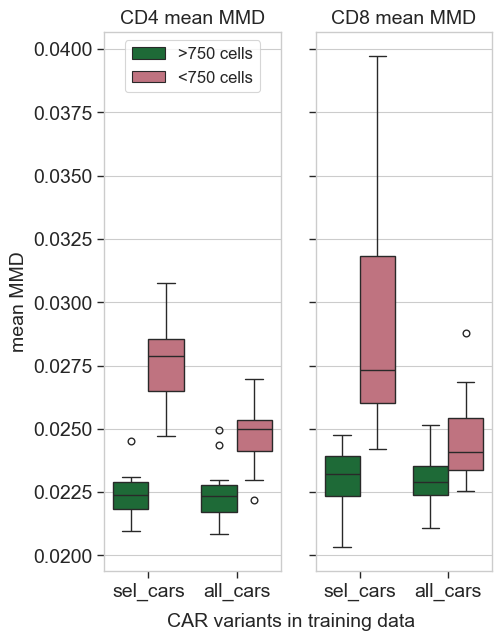

In [26]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(5,7))
for i, subset in enumerate(["CD4", "CD8"]):
    plt_data = all_res[(all_res["subset"]==subset)&(all_res["metric"]=="mean_mmd")]
    plt_data = plt_data.rename(columns={"eval_setting": ""})
    sns.boxplot(data=plt_data, y="score", ax=axes[i], hue="OOD_ID", x="model", palette=ID_OOD_map)
    axes[i].set_title(f"{subset} mean MMD", fontsize=14)
    axes[i].set_ylabel("mean MMD", fontsize=14)
    axes[i].set_xlabel("")
    axes[i].tick_params(which="both", axis="both", labelsize=14)

axes[1].get_legend().remove()
axes[0].legend(fontsize=12, loc="upper center")
fig.text(0.25, 0.03, "CAR variants in training data", fontsize=14)
plt.tick_params(which="both", axis="both", labelsize=14)
plt.savefig(f"{base_fig_save}MMD_all_sel_CARs_OOD_ID_performance.pdf", bbox_inches="tight")

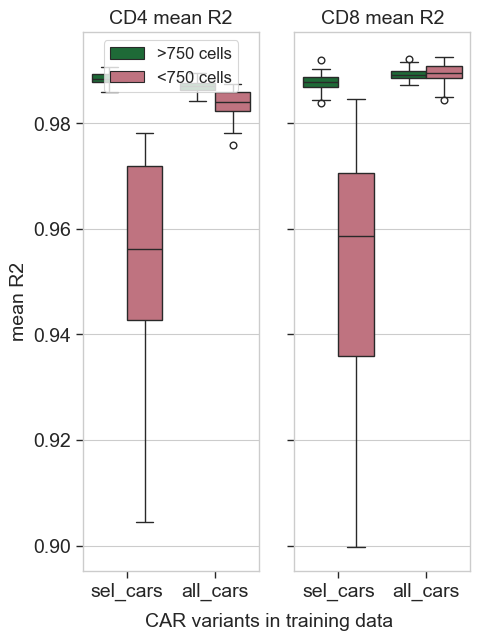

In [27]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(5,7))
for i, subset in enumerate(["CD4", "CD8"]):
    plt_data = all_res[(all_res["subset"]==subset)&(all_res["metric"]=="mean_r2")]
    plt_data = plt_data.rename(columns={"eval_setting": ""})
    sns.boxplot(data=plt_data, y="score", ax=axes[i], hue="OOD_ID", x="model", palette=ID_OOD_map)
    axes[i].set_title(f"{subset} mean R2", fontsize=14)
    axes[i].set_ylabel("mean R2", fontsize=14)
    axes[i].set_xlabel("")
    axes[i].tick_params(which="both", axis="both", labelsize=14)

axes[1].get_legend().remove()
axes[0].legend(fontsize=12, loc="upper center")
fig.text(0.25, 0.03, "CAR variants in training data", fontsize=14)
plt.tick_params(which="both", axis="both", labelsize=14)
plt.savefig(f"{base_fig_save}R2_all_sel_CARs_OOD_ID_performance.pdf", bbox_inches="tight")

In [28]:
all_res["eval_setting"].unique()

array(['conCAROT', 'conCAROT-OOD'], dtype=object)

In [29]:
all_res.loc[(all_res["model"]=="sel_cars")&(all_res["subset"]=="CD4")&(all_res["metric"]=="mean_r2")]


,metric,score,eval_car,eval_setting,subset,OOD_ID,model
5,mean_r2,0.990714,41BB-41BB-z,conCAROT,CD4,>750 cells,sel_cars
11,mean_r2,0.988026,41BB-CD28-z,conCAROT,CD4,>750 cells,sel_cars
17,mean_r2,0.987812,41BB-CD40-z,conCAROT,CD4,>750 cells,sel_cars
23,mean_r2,0.987888,41BB-IL15RA-z,conCAROT,CD4,>750 cells,sel_cars
29,mean_r2,0.988665,41BB-NA-z,conCAROT,CD4,>750 cells,sel_cars
35,mean_r2,0.989997,CD28-CD28-z,conCAROT,CD4,>750 cells,sel_cars
41,mean_r2,0.990050,CD28-CD40-z,conCAROT,CD4,>750 cells,sel_cars
47,mean_r2,0.989478,CD28-IL15RA-z,conCAROT,CD4,>750 cells,sel_cars
53,mean_r2,0.988405,CD28-NA-z,conCAROT,CD4,>750 cells,sel_cars
59,mean_r2,0.989040,CD40-IL15RA-z,conCAROT,CD4,>750 cells,sel_cars


In [30]:
all_res.loc[(all_res["model"]=="all_cars")&(all_res["subset"]=="CD4")&(all_res["metric"]=="mean_r2")]


,metric,score,eval_car,eval_setting,subset,OOD_ID,model
101,mean_r2,0.987841,41BB-41BB-z,conCAROT,CD4,>750 cells,all_cars
107,mean_r2,0.987713,41BB-CD28-z,conCAROT,CD4,>750 cells,all_cars
113,mean_r2,0.986722,41BB-CD40-z,conCAROT,CD4,>750 cells,all_cars
119,mean_r2,0.988050,41BB-IL15RA-z,conCAROT,CD4,>750 cells,all_cars
125,mean_r2,0.986997,41BB-NA-z,conCAROT,CD4,>750 cells,all_cars
131,mean_r2,0.988886,CD28-CD28-z,conCAROT,CD4,>750 cells,all_cars
137,mean_r2,0.989477,CD28-CD40-z,conCAROT,CD4,>750 cells,all_cars
143,mean_r2,0.987398,CD28-IL15RA-z,conCAROT,CD4,>750 cells,all_cars
149,mean_r2,0.985871,CD28-NA-z,conCAROT,CD4,>750 cells,all_cars
155,mean_r2,0.986910,CD40-IL15RA-z,conCAROT,CD4,>750 cells,all_cars
